# Homework 6

## Imports

In [1]:
import os
import random
import re
import string
from copy import deepcopy

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from captum.attr import InputXGradient, configure_interpretable_embedding_layer, visualization as vis
from cleanlab import Datalab
from datasets import Dataset, DatasetDict, load_dataset
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict
from transformers import EarlyStoppingCallback, pipeline, AutoTokenizer, AutoModelForSequenceClassification, \
    EvalPrediction, Trainer, TrainingArguments

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 1. Downloading and exploring the data

### Load dataset from hf

In [2]:
dataset = load_dataset("PolyAI/banking77", trust_remote_code=True)
df_raw = dataset["train"].to_pandas()
print(df_raw.head())

print(f"Number of classes: {dataset['train'].features['label'].num_classes}")
print(f"Number of training samples: {len(dataset['train'])}")

                                                text  label
0                     I am still waiting on my card?     11
1  What can I do if my card still hasn't arrived ...     11
2  I have been waiting over a week. Is the card s...     11
3  Can I track my card while it is in the process...     11
4  How do I know if I will get my card, or if it ...     11
Number of classes: 77
Number of training samples: 10003


In [3]:
label_names = dataset["train"].features["label"].names

for i, name in enumerate(label_names):
    print(f"{i}: {name}")

0: activate_my_card
1: age_limit
2: apple_pay_or_google_pay
3: atm_support
4: automatic_top_up
5: balance_not_updated_after_bank_transfer
6: balance_not_updated_after_cheque_or_cash_deposit
7: beneficiary_not_allowed
8: cancel_transfer
9: card_about_to_expire
10: card_acceptance
11: card_arrival
12: card_delivery_estimate
13: card_linking
14: card_not_working
15: card_payment_fee_charged
16: card_payment_not_recognised
17: card_payment_wrong_exchange_rate
18: card_swallowed
19: cash_withdrawal_charge
20: cash_withdrawal_not_recognised
21: change_pin
22: compromised_card
23: contactless_not_working
24: country_support
25: declined_card_payment
26: declined_cash_withdrawal
27: declined_transfer
28: direct_debit_payment_not_recognised
29: disposable_card_limits
30: edit_personal_details
31: exchange_charge
32: exchange_rate
33: exchange_via_app
34: extra_charge_on_statement
35: failed_transfer
36: fiat_currency_support
37: get_disposable_virtual_card
38: get_physical_card
39: getting_spar

### Basic Data Exploration

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [5]:
df_raw.head(10)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my n...,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11


In [6]:
df_raw.tail(10)

,text,label
9993,can I use it all over the world?,24
9994,Do you work in Greece?,24
9995,What countries do your accounts support?,24
9996,I live in the US and I would like to get a car...,24
9997,I just moved to the US how do I get a card?,24
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24
10002,Which countries are represented?,24


**Number of null values in columns**

In [8]:
print(f"Number of nulls in 'label': {df_raw['label'].isnull().sum()}")
print(f"Number of nulls in 'text': {df_raw['text'].isnull().sum()}")

Number of nulls in 'label': 0
Number of nulls in 'text': 0


**Common texts**

In [7]:
print(f"Unique texts count: {len(df_raw['text'].unique())}")
print(f"Dataset len: {len(df_raw)}")

Unique texts count: 10003
Dataset len: 10003


In [9]:
def uncase_and_without_spaces(text: str) -> str:
    return text.lower().strip()


print(f"Unique texts count: {len(df_raw['text'].apply(uncase_and_without_spaces).unique())}")
print(f"Dataset len: {len(df_raw)}")

Unique texts count: 9999
Dataset len: 10003


Almost all of texts are unique.

**Classes distribution**

In [10]:
labels_count = df_raw["label"].value_counts()
labels_count

label
15    187
28    182
6     181
75    180
19    177
     ... 
41     82
18     61
10     59
72     41
23     35
Name: count, Length: 77, dtype: int64

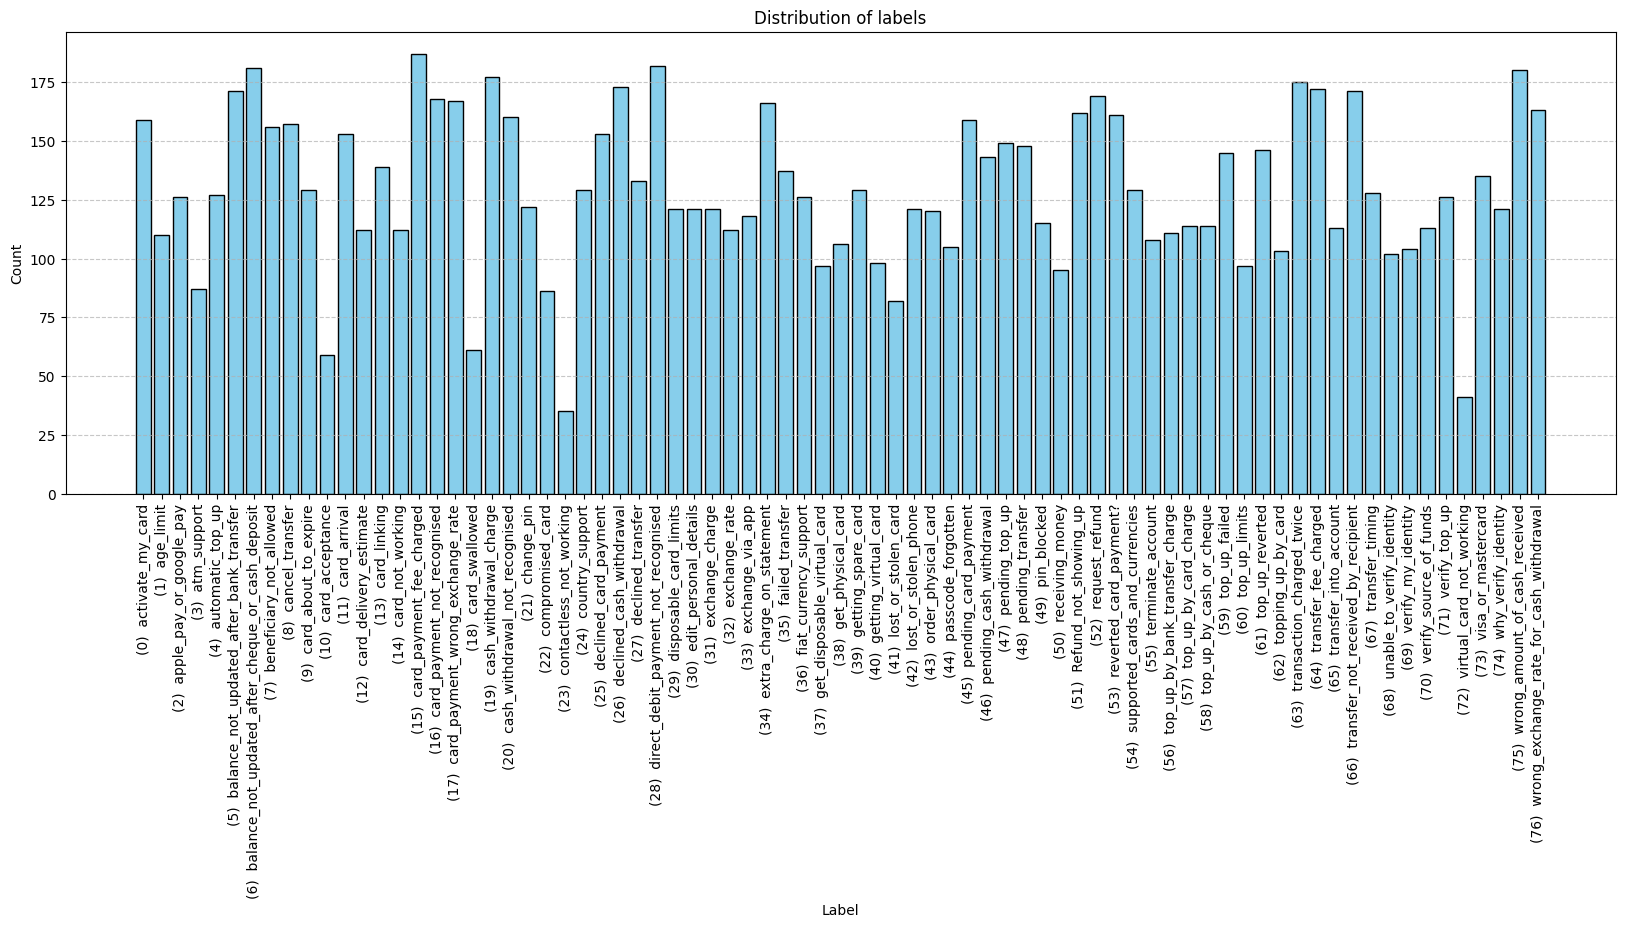

In [12]:
plt.figure(figsize=(20, 6))
plt.bar(labels_count.index, labels_count.values, color='skyblue', edgecolor='black')
plt.xticks(labels_count.index, [f"({i})  {label_names[i]}" for i in labels_count.index], rotation=90)
plt.title("Distribution of labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [13]:
labels_count_sorted = labels_count.sort_values()
labels_count_sorted.head(10)

label
23    35
72    41
10    59
18    61
41    82
22    86
3     87
50    95
60    97
37    97
Name: count, dtype: int64

Some of the labels are less popular in the dataset.

**text length distribution**

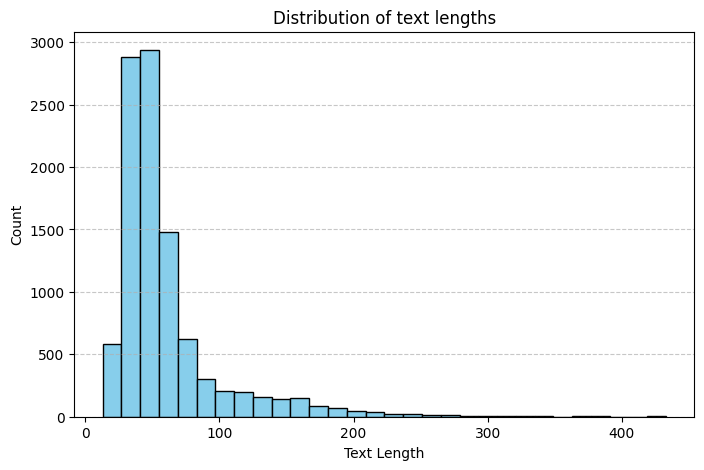

In [14]:
text_length = df_raw['text'].apply(len)

plt.figure(figsize=(8, 5))
plt.hist(text_length, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of text lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
short_texts = text_length[text_length < 100]
short_prc = (len(short_texts) / len(text_length)) * 100
print(f"Number of short texts (<100 chars): {len(short_texts)}. It is {short_prc:.2f}% of the dataset.")

Number of short texts (<100 chars): 8868. It is 88.65% of the dataset.


Majority of texts are short, with lengths less than 100 characters.

## 2. Cleanlab for data quality

### Model preparation

In [17]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
clf = LogisticRegressionCV(solver="lbfgs", max_iter=500, class_weight="balanced")


def get_initial_model_data(texts: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    embeddings = embedding_model.encode(texts, convert_to_numpy=True)
    pred_probs = cross_val_predict(clf, embeddings, labels, cv=5, method="predict_proba")
    return embeddings, pred_probs

In [18]:
texts = df_raw["text"].values
labels = df_raw["label"].values

embeddings, pred_probs = get_initial_model_data(texts, labels)

### Datalab 

In [19]:
data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 633 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         151
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

There are a lot of issues that should be fixed in the dataset.

**Label issues examination and fixing**

In [20]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print("====" * 30)
    print(f"y_true: {label_names[y_true]} ({y_true})\ny_pred {label_names[y_pred]} ({y_pred})\ntext: {text}")
    print()

Top 10 label issues
y_true: card_arrival (11)
y_pred card_not_working (14)
text: WHAT IS THE SOLUTION OF THIS PROBLEM

y_true: disposable_card_limits (29)
y_pred getting_virtual_card (40)
text: i am not a premium customer but i want a virtual card, how do i get it

y_true: lost_or_stolen_card (41)
y_pred card_arrival (11)
text: Can you tell me the status of my new card?

y_true: declined_transfer (27)
y_pred beneficiary_not_allowed (7)
text: please help me with this transfer, for some reason i can't transfer to a cryptocurency account

y_true: pending_top_up (47)
y_pred topping_up_by_card (62)
text: i put money on my card and i dont see it on the balance

y_true: card_not_working (14)
y_pred pin_blocked (49)
text: Can I use app to reset PIN attempts?

y_true: pin_blocked (49)
y_pred get_physical_card (38)
text: Where do I find PIN for my card?

y_true: declined_cash_withdrawal (26)
y_pred card_not_working (14)
text: Is my card actually working? It's the first time I tried using it

y_t

Clearly, many of labels should be as model predicted them. Howerver, not all of them. Some of them are just unrelated or rubish in my opinion (eq.  2nd example above).

Score 0.981 is not that bad. So **I will leave it as it is**. Moreover there are less than 2% of data mislabeled.  However in the real life scenario it is easy to fix (but time consuming). Recipe for fixing:
- watch all 149 examples
- those that not make any sense - remove
- those that are clearly mislabelled - fix the label
- those that are ambiguous - leave as is

Then the model should perform much better.

**Near duplicates examination and fixing**

In [21]:
near_duplicate_issues = lab.get_issues("near_duplicate")
near_duplicate_issues = near_duplicate_issues[near_duplicate_issues["is_near_duplicate_issue"]]
near_duplicate_issues = near_duplicate_issues.sort_values(by="near_duplicate_score")

for idx, row in near_duplicate_issues.head(10).iterrows():
    text = texts[idx]
    label_true = labels[idx]
    label_true_name = label_names[label_true]

    neighbor_indices = row["near_duplicate_sets"][:3]

    print("====" * 30)
    print(f"Text: {text.strip()}")
    print(f"Label: {label_true_name} ({label_true})")
    print("Duplicates:")

    for ni in neighbor_indices:
        dup_text = texts[ni]
        dup_label = labels[ni]
        dup_label_name = label_names[dup_label]
        print(f" - [{dup_label_name} ({dup_label})] {dup_text.strip()}")

    print()


Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
Label: pin_blocked (49)
Duplicates:
 - [pin_blocked (49)] I put the wrong pin too many times and now it is blocked. Can you help me unblock it?

Text: I can't seem to be able to use my card
Label: card_not_working (14)
Duplicates:
 - [card_not_working (14)] I can't seem to be able to use my card

Text: I can't seem to be able to use my card
Label: card_not_working (14)
Duplicates:
 - [card_not_working (14)] I can't seem to be able to use my card

Text: Where can I withdraw money from?
Label: atm_support (3)
Duplicates:
 - [atm_support (3)] Where can I withdraw money from?

Text: Where can I withdraw money from?
Label: atm_support (3)
Duplicates:
 - [atm_support (3)] Where can I withdraw money from?

Text: How can I reset my passcode?
Label: passcode_forgotten (44)
Duplicates:
 - [passcode_forgotten (44)] How can i reset my passcode ?
 - [passcode_forgotten (44)] How do I reset my passcode?

Text

These are really near duplicates. The difference is in top 10 case by "do" <-> "can" or even just sign "\n". Some of them look the same. To prevent that, duplicates that differ in only one char oshould be removed from the dataset.

Instances to remove:
- only one char differ - to remove missclick duplicates
- only case differ
- extra spaces


Duplicates that differ by one word or tense are acceptable.

In [22]:
def normalize_text(s):
    s = s.strip()
    s = s.replace("’", "'")
    s = ''.join(c for c in s if c not in string.punctuation)
    s = re.sub(r"\s+", " ", s)
    return s.strip().lower()


def differ_by_one_char(a, b):
    if abs(len(a) - len(b)) > 1:
        return False
    diff = 0
    for x, y in zip(a, b):
        if x != y:
            diff += 1
            if diff > 1:
                return False
    return True


df_raw["normalized_text"] = df_raw["text"].apply(normalize_text)
print(f"Unique normalized texts count: {len(df_raw['normalized_text'].unique())}")

Unique normalized texts count: 9993


In [23]:
to_remove = set()
normalized = [normalize_text(t) for t in texts]

for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        a = texts[i]
        b = texts[j]
        na = normalized[i]
        nb = normalized[j]

        if na == nb:
            to_remove.add(j)
            continue

        if differ_by_one_char(na, nb):
            to_remove.add(j)
            continue

print(f"Number of instances to remove: {len(to_remove)}")

Number of instances to remove: 29


In [25]:
df_deduplicated = df_raw.drop(index=list(to_remove)).reset_index(drop=True)

print(f"Original dataset size: {len(df_raw)}")
print(f"Deduplicated dataset size: {len(df_deduplicated)}")

Original dataset size: 10003
Deduplicated dataset size: 9974


In [26]:
df_deduplicated.head(10)

,text,label,normalized_text
0,I am still waiting on my card?,11,i am still waiting on my card
1,What can I do if my card still hasn't arrived ...,11,what can i do if my card still hasnt arrived a...
2,I have been waiting over a week. Is the card s...,11,i have been waiting over a week is the card st...
3,Can I track my card while it is in the process...,11,can i track my card while it is in the process...
4,"How do I know if I will get my card, or if it ...",11,how do i know if i will get my card or if it i...
5,When did you send me my new card?,11,when did you send me my new card
6,Do you have info about the card on delivery?,11,do you have info about the card on delivery
7,What do I do if I still have not received my n...,11,what do i do if i still have not received my n...
8,Does the package with my card have tracking?,11,does the package with my card have tracking
9,I ordered my card but it still isn't here,11,i ordered my card but it still isnt here


In [29]:
df_clean = df_deduplicated.drop(columns=["normalized_text"])
df_clean.head(10)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my n...,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11


**Comment on the data cleaning process**

I partially agree with the authors of the paper https://aclanthology.org/2022.insights-1.19.pdf. However, they indicating that there are almost 14% of mislabeled examples in the dataset. In my opinion, it is too much. I've encountered only about 2% of such examples, by analysis with use of Cleanlab. This diference may be due to the fact that I did not manually check all the examples indicated by Cleanlab as mislabeled. However, many of them looked quite correct to me.

Another mentioned issue in the dataset is that near dupliaces have different labels. Again, for checking top 10 near duplicates from CleanLab there is no difference in labels for such examples. Furthermore, after checking top 50 examples of near duplicates, after quick look I haven't found more.


**are the problems severe and worth fixing in your opinion?**

In my opinion all data problems that can be fixed quickly are worth fixing. Furthermore, these types of problems can indicate that something in software may be wrong so for example high amount of labels are wrong. Overall, it is definitelly worth analyzing and if it is easy to fix - do it. Based on paper it can lead to significant model performance improvement.



## 3. Training small text classifier

### Deterministic settings

In [27]:
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

### Creating datasets

In [30]:
valid_size = int(0.2 * len(df_clean))
train_size = int(0.8 * len(df_clean))

df_train, df_val = train_test_split(df_clean, test_size=valid_size, random_state=0, stratify=df_clean["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_val, split="valid")

print(f"Training samples: {len(datasets_dict['train'])}")
print(f"Validation samples: {len(datasets_dict['valid'])}")

Training samples: 7980
Validation samples: 1994


In [32]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7980 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

### Defining model

In [46]:
num_cores = joblib.cpu_count(only_physical_cores=True)
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)
model.to(device="cuda" if torch.cuda.is_available() else "cpu")

for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from sklearn.metrics import f1_score, accuracy_score


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)
    y_pred = torch.argmax(logits, dim=1).numpy()

    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = accuracy_score(y_true, y_pred)

    return {"f1": f1, "accuracy": acc}


No hyperparameter optimization will be performed. I will use lower learning rate and train longer. Below there is a device that I will train on.

In [35]:
!nvidia-smi

Mon Nov 17 18:42:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:07:00.0 Off |                    0 |
| N/A   26C    P0             63W /  400W |     913MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [47]:
callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

training_args = TrainingArguments(
    output_dir="finetuned_model",
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    num_train_epochs=150,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,

    logging_steps=10,
    load_best_model_at_end=True,

    seed=0,
    data_seed=0,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=callbacks
)
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,4.348700,4.343131,0.002079,0.013039
2,4.338600,4.328025,0.004589,0.018556
3,4.321200,4.304907,0.009333,0.029087
4,4.295700,4.274303,0.007725,0.034604
5,4.263200,4.236207,0.020292,0.044132
6,4.223900,4.189124,0.048377,0.075226
7,4.174600,4.128064,0.103241,0.141424
8,4.104500,4.046024,0.130923,0.174524
9,4.020600,3.944809,0.149621,0.197593
10,3.912700,3.825129,0.215091,0.252257


TrainOutput(global_step=37500, training_loss=1.468643564860026, metrics={'train_runtime': 648.1916, 'train_samples_per_second': 1846.676, 'train_steps_per_second': 57.853, 'total_flos': 3.036846691750697e+16, 'train_loss': 1.468643564860026, 'epoch': 150.0})

### Training plots

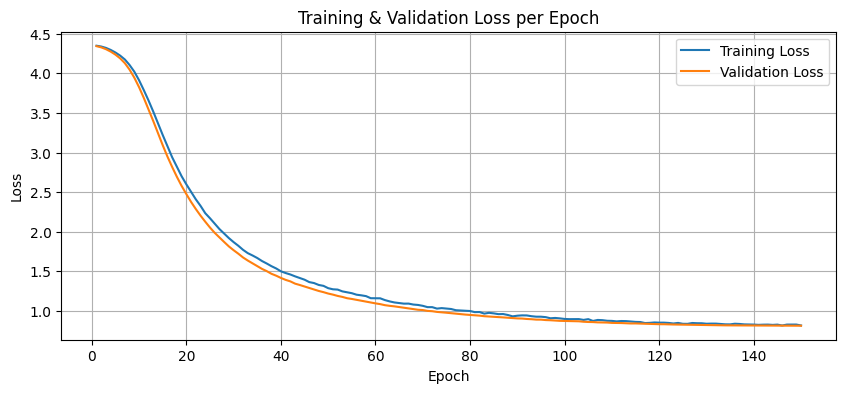

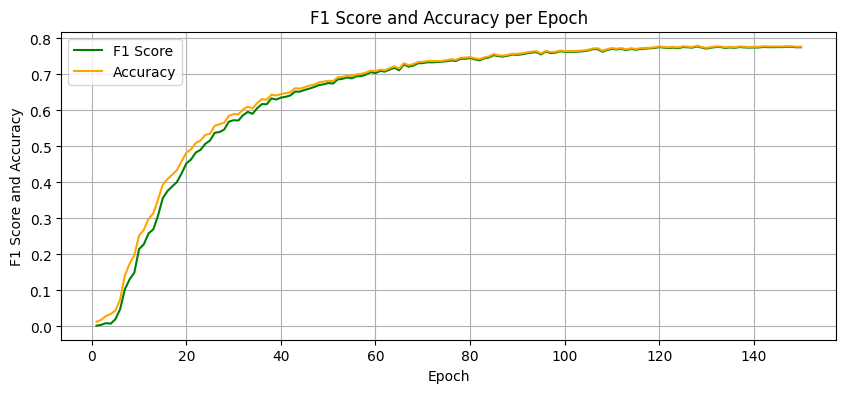

In [49]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

train_loss_epochs = [x['loss'] for x in history if 'loss' in x and 'epoch' in x]
epochs_for_loss = [x['epoch'] for x in history if 'loss' in x and 'epoch' in x]

eval_loss_epochs = [x['eval_loss'] for x in history if 'eval_loss' in x and 'epoch' in x]
eval_f1_epochs = [x['eval_f1'] for x in history if 'eval_f1' in x and 'epoch' in x]
eval_acc_epochs = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x and 'epoch' in x]
epochs_for_eval = [x['epoch'] for x in history if 'eval_loss' in x and 'epoch' in x]

plt.figure(figsize=(10, 4))
plt.plot(epochs_for_loss, train_loss_epochs, label='Training Loss')
plt.plot(epochs_for_eval, eval_loss_epochs, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs_for_eval, eval_f1_epochs, label='F1 Score', color='green')
plt.plot(epochs_for_eval, eval_acc_epochs, label='Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("F1 Score and Accuracy")
plt.title("F1 Score and Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


Model trained very well :)

In [50]:
def load_trained_model(model_dir: str):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    return model, tokenizer

In [51]:
model, tokenizer = load_trained_model("finetuned_model/checkpoint-37500")

## 4. Model Testing

Metrics that will be tested:

- overall accuracy,
- overall precision,
- overall recall,
- overall f1,
- accuracy per class,
- f1 per class

In [52]:
model.eval()

y_true = []
y_pred = []

for batch in datasets_tokenized["valid"]:
    input_ids = torch.tensor(batch['input_ids']).unsqueeze(0)
    attention_mask = torch.tensor(batch['attention_mask']).unsqueeze(0)
    labels = batch['label']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=-1).item()

    y_pred.append(pred)
    y_true.append(labels)

In [53]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8750    0.8750    0.8750        32
           1     0.9167    1.0000    0.9565        22
           2     0.9524    0.8000    0.8696        25
           3     0.8000    0.7059    0.7500        17
           4     0.7931    0.9200    0.8519        25
           5     0.7692    0.5882    0.6667        34
           6     0.6889    0.8611    0.7654        36
           7     0.8400    0.6774    0.7500        31
           8     0.8387    0.8387    0.8387        31
           9     0.9091    0.7692    0.8333        26
          10     0.9091    0.8333    0.8696        12
          11     0.6316    0.7742    0.6957        31
          12     0.6957    0.7273    0.7111        22
          13     0.8750    0.7500    0.8077        28
          14     0.9412    0.7273    0.8205        22
          15     0.7045    0.8378    0.7654        37
          16     0.7105    0.8182    0.7606        33
          17     0.8788    

In [54]:
def get_label_name(idx):
    try:
        return label_names[int(idx)]
    except (ValueError, KeyError):
        return idx


report_dict = classification_report(y_true, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report_dict).transpose()
metrics_df['class_name'] = metrics_df.index.map(get_label_name)
metrics_df_sorted = metrics_df.sort_values(by='f1-score', ascending=True)

### Checking worst performing classes by f1

In [56]:
top10_worst = metrics_df_sorted.head(10)
print(top10_worst)

    precision    recall  f1-score  support                          class_name
62   0.500000  0.300000  0.375000     20.0                  topping_up_by_card
23   1.000000  0.285714  0.444444      7.0             contactless_not_working
50   0.578947  0.578947  0.578947     19.0                     receiving_money
35   0.488372  0.777778  0.600000     27.0                     failed_transfer
39   0.625000  0.576923  0.600000     26.0                  getting_spare_card
53   0.655172  0.593750  0.622951     32.0              reverted_card_payment?
48   0.833333  0.500000  0.625000     30.0                    pending_transfer
65   0.548387  0.739130  0.629630     23.0               transfer_into_account
66   0.677419  0.617647  0.646154     34.0  transfer_not_received_by_recipient
27   0.750000  0.576923  0.652174     26.0                   declined_transfer


### Checking best performing classes by f1

In [57]:
top10_best = metrics_df_sorted.tail(10)
print(top10_best)

    precision    recall  f1-score  support             class_name
55   0.846154  1.000000  0.916667     22.0      terminate_account
30   0.884615  0.958333  0.920000     24.0  edit_personal_details
60   0.900000  0.947368  0.923077     19.0          top_up_limits
32   0.880000  1.000000  0.936170     22.0          exchange_rate
1    0.916667  1.000000  0.956522     22.0              age_limit
24   0.961538  0.961538  0.961538     26.0        country_support
71   0.925926  1.000000  0.961538     25.0          verify_top_up
73   0.931034  1.000000  0.964286     27.0     visa_or_mastercard
36   1.000000  0.960000  0.979592     25.0  fiat_currency_support
44   1.000000  1.000000  1.000000     21.0     passcode_forgotten


**comment:**
- F1 in paper were around 0.87 and 0.92 which is much better that I was able to achieve. Such difference can be caused by different embedding model. 
- However, my 0.77 f1 score is in my opinion high enough. My model also could be even more accurate if only it would be trained for longer. It hasn't reached the early stopping. 
- There are some significant differences between classes. It is highlighted in best 10 and worst 10 classes. The maximum difference in f1 score is 0.625. As we can see, there are some classes with metrics at max level, while others are at level of 0.5. This indicates that classes are inbalanced or some of them are easier to recognize. 

Overall model has some issues with being biased into some labels, but it is definitelly trained.

## 5. Behavioral model testing

### Setup

In [66]:
model.eval()
model_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
    return_all_scores=True
)

Device set to use cuda


### Prediction functoin

In [75]:
@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist(), top_k=None)

    y_pred_proba = []

    for sample_preds in pred_output:
        probs = [0.0] * len(label_names)
        for pred in sample_preds:
            label2id = model.config.label2id
            idx = label2id[pred["label"]]
            probs[idx] = pred["score"]
        y_pred_proba.append(probs)

    return np.array(y_pred_proba)

In [77]:
giskard_dataset = GiskardDataset(df_val, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=[i for i in range(77)],
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

2025-11-17 19:28:08,317 pid:3649972 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-17 19:28:08,318 pid:3649972 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-17 19:28:08,325 pid:3649972 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-17 19:28:08,369 pid:3649972 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.048665
2025-11-17 19:28:08,377 pid:3649972 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-17 19:28:08,384 pid:3649972 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.011715
2025-11-17 19:28:08,389 pid:3649972 MainThread giskard.

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


2025-11-17 19:28:33,842 pid:3649972 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (100, 2) executed in 0:00:00.376316
2025-11-17 19:28:33,844 pid:3649972 MainThread giskard.scanner.logger INFO     DataLeakageDetector: Running
2025-11-17 19:28:33,850 pid:3649972 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-17 19:28:33,852 pid:3649972 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1994, 2) executed in 0:00:00.007547
2025-11-17 19:28:33,858 pid:3649972 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-17 19:28:33,865 pid:3649972 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.007025
2025-11-17 19:28:33,868 pid:3649972 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'objec

<iframe id="scan-22603244058256" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse

### Results analysis

There are some problems according to the Giskard

1) For text containing "money" the precision is significantly lower (18.69%) than for the global. Simirarly for the "transfer" and "account", but it is lower only by 6.73% and 9,70% respectively. However, after checking and veryfing the examples provided by framework, in my opinion predictions are good enough. This can be cause by not enough prepreocssing and cleaning the data or because some classes has less examples.

2) More attetion should be paid to the ethical behavior. For small changes (eg. gender), models changed their prediction. It is labeled as major issue. Further more, only 0.7% and 2.5% of the dataset is affected, so it is not such problem I think. For changing gender or low to high income country it shouldn't be very influencial on model answer. It could be solved by adding some little different exmaples, eg. change some values.

3) The biggest problem is in robustness. For small changes in add typos caused 45.8% of the tested sample. It is very high percentage and is real problem. Typos should be ignored by the model, because it doesn't change the context of the text. It is just a mistake. Additionally, punctuation removal also is high 16% and transformig numbers to word 17%. Can be solved as above.

Model has some real issues that should be solved.

## 6. Captum local explainability

### Setup

In [111]:
class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    for param in model.distilbert.parameters():
        param.requires_grad = True

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        y_pred = np.argmax(probs)

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=int(y_true),
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=probs[y_pred],
        pred_class=y_pred,
        true_class=y_true,
        attr_class=y_pred,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])


In [109]:
samples = df_val[15:20]
samples["class_name"] = samples["label"].apply(lambda x: label_names[int(x)])
samples

,text,label,class_name
3858,What is my identification used for?,74,why_verify_identity
3154,I think my top up has been reverted,61,top_up_reverted
5926,"I made a card payment, but it has been declined?",25,declined_card_payment
1062,How soon will I get my card?,12,card_delivery_estimate
5178,I got some items this morning but the payment ...,45,pending_card_payment


In [112]:
for idx, row in samples.iterrows():
    explain_text(model, text=row["text"], y_true=row["label"])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
74,69 (0.66),69,-0.38,what is my identification used for ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
61,61 (0.66),61,1.02,i think my top up has been reverted


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
25,25 (0.47),25,-0.22,"i made a card payment , but it has been declined ?"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
12,12 (0.60),12,-1.14,how soon will i get my card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
45,45 (0.76),45,0.57,i got some items this morning but the payment says pending


Only first prediction was wrong there and the probability of that label is high (0.66). Looking at the real label name: "why_verify_identity" - the real label is accurate in this case. The identification word is negative (**??**) for the prediction what is strange looking at the class name. It should make prediction "closer" to that real class.


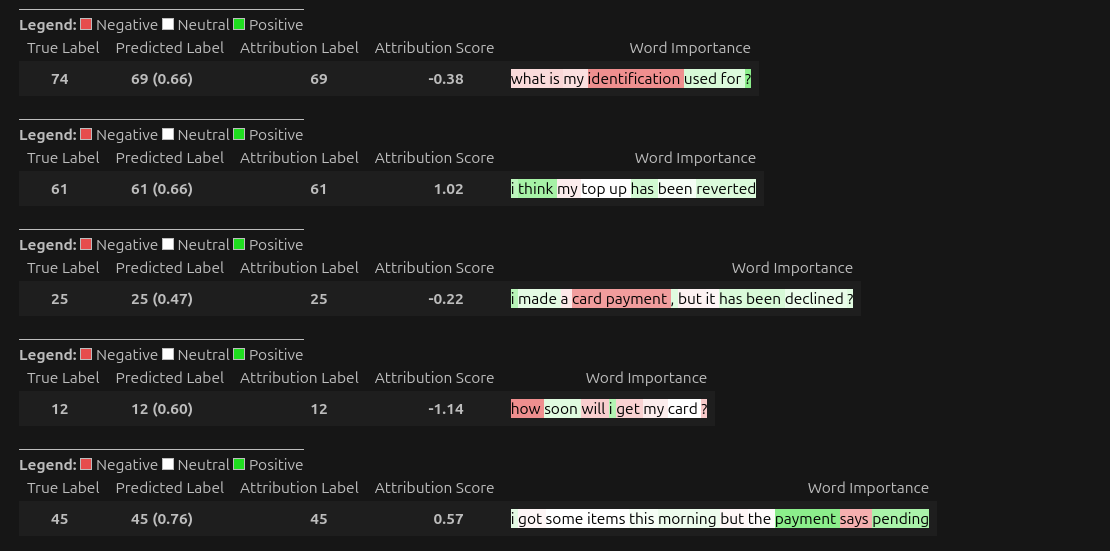